In [1]:
# Import modules
import numpy as np
import pandas as pd
import rosbag
import os
import yaml
import random
import math as m
from scipy.spatial.distance import cdist
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error


# Import PySwarms
import pyswarms as ps
import sys
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
#function for changing the parameter values (YAML file is used for the params to be called from the main UKF program)
def tes_yaml(P,Q):
    with open('/home/tartila/catkin_ws/src/golfi/config/ukf_ule_ga_params.yaml') as tes:             
        doc=yaml.safe_load(tes)
    if Q is not None:
        doc['process_noise_covariance_Q'] = Q
        doc['initial_estimate_covariance_P'] = P
   
    with open('/home/tartila/catkin_ws/src/golfi/config/ukf_ule_ga_params.yaml','w') as tes:      #save as
        yaml.safe_dump(doc, tes, indent=2, allow_unicode=False) #dah berhasil ni    

In [3]:
#function for launching the 3 nodes: rosbag play back, the ukf algorithm, the recording of the rosbag to a temporary rosbag file that saves the estimation from the UKF
def launch():
    !roslaunch /home/tartila/catkin_ws/src/golfi/launch/ukf_ule_ga.launch

In [4]:
#function for loading the estimation values recorded in the temporary bag file
def ambil_bag():
    bag = rosbag.Bag('ga_temp.bag')
#     print(bag)
    states_xy=[]
    states_xy_baru=[]
    t = []

    for topic, msg, time in bag.read_messages(topics=['/ukf_states']):
        states_xy.append([msg.x,msg.y])
        t.append(msg.stamp.to_sec())
    
    states_xy = np.array(states_xy)
    t = np.array(t)
    
    states_xy = states_xy[np.all(states_xy != 0,axis = 1)] #buang yg 0
    states_xy = states_xy[np.all(~np.isnan(states_xy),axis = 1)] #buang yg nan
    t = t[t != 0]

    utm=[]
    utm_baru=[]
    t_utm = []

    for topic, msg, time in bag.read_messages(topics=['/utm']):
        utm.append([msg.pose.pose.position.x,msg.pose.pose.position.y])
        t_utm.append(time.to_sec())
        
    utm = np.array(utm)
    t_utm = np.array(t_utm)

    min = utm[0]

    i=0
    for a in states_xy:
        states_xy_baru.append([states_xy[i,0]-min[0],states_xy[i,1]-min[1]])
        i=i+1
    states_xy_baru=np.array(states_xy_baru)
    
    i=0
    for a in utm:
        utm_baru.append([utm[i,0]-min[0],utm[i,1]-min[1]])
        i=i+1
    utm_baru=np.array(utm_baru)
    return states_xy_baru, utm_baru, t, t_utm

def err2(est, gt, t_est, t_gt):
    j = 1
    sample_est = []
    sample_gt = []
    for i in range(1, len(t_gt)):
        while (t_gt[i] > t_est[j]):
            j += 1
            
        sample_est.append(est[j])
        sample_gt.append(gt[i])
    rmsee=sqrt(mse(sample_gt, sample_est))
    print("rmse: "+str(rmsee))
    return rmsee


In [5]:
#function for plotting the estimation and the (unextended) GNSS points 
def plot(estimasi,gnss):
    plt.figure(figsize=(10,10))
    matplotlib.style.use('default')

    plt.scatter(estimasi[:,0],estimasi[:,1],s=2.,color='k') #odometry/filtered_map
    plt.scatter(gnss[:,0],gnss[:,1],s=5.,marker="x",c='C3',alpha=1)
    plt.show()
    

In [6]:
swarm_size = 20
dim = 10 # Dimension of X
epsilon = 1.0
errorr = []
options = {'c1': 0.5, 'c2':0.5, 'w':0.5}


constraints = (np.array([0,0,0,0,0,0,0,0,0,0]),
               np.array([30,30,30,30,30,30,30,30,30,30]))


In [7]:

def error1(X):
    P = np.array([X[0],0,0,0,0,0,X[1],0,0,0,0,0,X[2],0,0,0,0,0,X[3],0,0,0,0,0,X[4]])
    P = P.flatten().tolist()
    Q = np.array([X[5],0,0,0,0,0,X[6],0,0,0,0,0,X[7],0,0,0,0,0,X[8],0,0,0,0,0,X[9]])
    Q = Q.flatten().tolist()
    tes_yaml(P,Q)
    launch()
    hasil_ukf, utm, t_state, t_utm = ambil_bag()
    plot(hasil_ukf,utm)
    
    # Get the overall transformation matrix
    pos = err2(hasil_ukf, utm, t_state, t_utm)
    errorr.append(pos)
    return pos



In [8]:
def error2(X):
    P = np.array([X[0],0,0,0,0,0,X[1],0,0,0,0,0,X[2],0,0,0,0,0,X[3],0,0,0,0,0,X[4]])
    P = P.flatten().tolist()
    Q = np.array([X[5],0,0,0,0,0,X[6],0,0,0,0,0,X[7],0,0,0,0,0,X[8],0,0,0,0,0,X[9]])
    Q = Q.flatten().tolist()
    tes_yaml(P,Q)
    launch()
    hasil_ukf, utm, t_state, t_utm = ambil_bag()
    plot(hasil_ukf,utm)
    
    # Get the overall transformation matrix
    pos = err2(hasil_ukf, utm, t_state, t_utm)
    errorr.append(pos)
    return pos

In [9]:

def opt_func(X):
    n_particles = X.shape[0]  # number of particles
    rmse_min = [(error2(X[i])) for i in range(n_particles)]
    return np.array(rmse_min)




2021-02-26 00:05:12,022 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/20

... logging to /home/tartila/.ros/log/632b1722-777e-11eb-ae06-74c63b0b1efd/roslaunch-tartila-G551VW-16846.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
It's recommended that you use the 'rosclean' command.
]2;/home/tartila/catkin_ws/src/golfi/launch/ukf_ule_ga.launch
started roslaunch server http://tartila-G551VW:34711/

SUMMARY

CLEAR PARAMETERS
 * /rosbag_play/
 * /rosbag_record/

PARAMETERS
 * /R_enc: 1e-06
 * /R_gnss: [0.09843, 0, 0, 0...
 * /R_imu: 1.894e-06
 * /R_tach: 5.538e-06
 * /initial_estimate_covariance_P: [23.4476109454510...
 * /process_noise_covariance_Q: [12.0408033454513...
 * /rosdistro: melodic
 * /rosversion: 1.14.10

NODES
  /
    rosbag_play (rosbag/play)
    rosbag_record (rosbag/record)
    ukf_localization_2d_ori (golfi/ukf_localization_2d_ori)
    utm (gps_common/utm_odometry_node)

ROS_MASTER_URI=http://localhost:11311
]2;/home/tartila/catkin_ws/src/golfi/launch/ukf_ule_ga.launch http://localhost:11311
proces

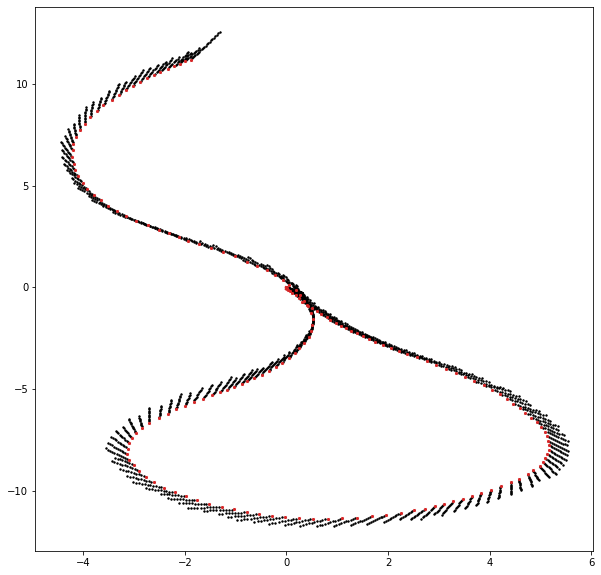

rmse: 0.2865730767915188
... logging to /home/tartila/.ros/log/632b1722-777e-11eb-ae06-74c63b0b1efd/roslaunch-tartila-G551VW-16913.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
It's recommended that you use the 'rosclean' command.
]2;/home/tartila/catkin_ws/src/golfi/launch/ukf_ule_ga.launch
started roslaunch server http://tartila-G551VW:43751/

SUMMARY

CLEAR PARAMETERS
 * /rosbag_play/
 * /rosbag_record/

PARAMETERS
 * /R_enc: 1e-06
 * /R_gnss: [0.09843, 0, 0, 0...
 * /R_imu: 1.894e-06
 * /R_tach: 5.538e-06
 * /initial_estimate_covariance_P: [10.1970576259842...
 * /process_noise_covariance_Q: [13.0260963467107...
 * /rosdistro: melodic
 * /rosversion: 1.14.10

NODES
  /
    rosbag_play (rosbag/play)
    rosbag_record (rosbag/record)
    ukf_localization_2d_ori (golfi/ukf_localization_2d_ori)
    utm (gps_common/utm_odometry_node)

ROS_MASTER_URI=http://localhost:11311
]2;/home/tartila/catkin_ws/src/golfi/launch/ukf_ule_ga.launch http:

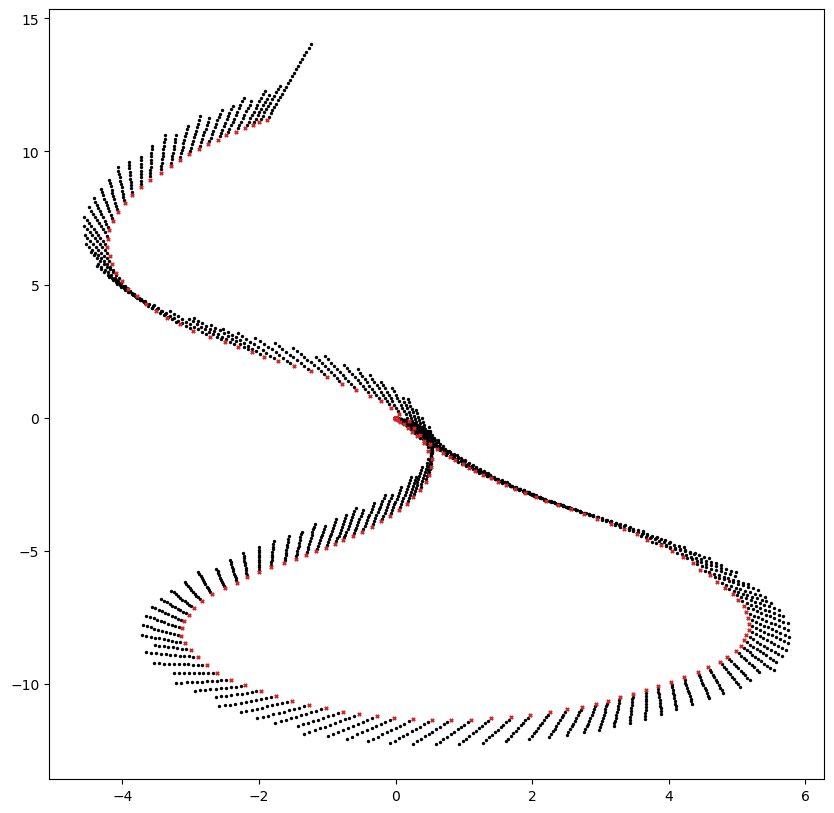

rmse: 0.566786045363965
... logging to /home/tartila/.ros/log/632b1722-777e-11eb-ae06-74c63b0b1efd/roslaunch-tartila-G551VW-16978.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
It's recommended that you use the 'rosclean' command.
]2;/home/tartila/catkin_ws/src/golfi/launch/ukf_ule_ga.launch
started roslaunch server http://tartila-G551VW:38173/

SUMMARY

CLEAR PARAMETERS
 * /rosbag_play/
 * /rosbag_record/

PARAMETERS
 * /R_enc: 1e-06
 * /R_gnss: [0.09843, 0, 0, 0...
 * /R_imu: 1.894e-06
 * /R_tach: 5.538e-06
 * /initial_estimate_covariance_P: [8.35478094740623...
 * /process_noise_covariance_Q: [12.3754843031163...
 * /rosdistro: melodic
 * /rosversion: 1.14.10

NODES
  /
    rosbag_play (rosbag/play)
    rosbag_record (rosbag/record)
    ukf_localization_2d_ori (golfi/ukf_localization_2d_ori)
    utm (gps_common/utm_odometry_node)

ROS_MASTER_URI=http://localhost:11311
]2;/home/tartila/catkin_ws/src/golfi/launch/ukf_ule_ga.launch http:/

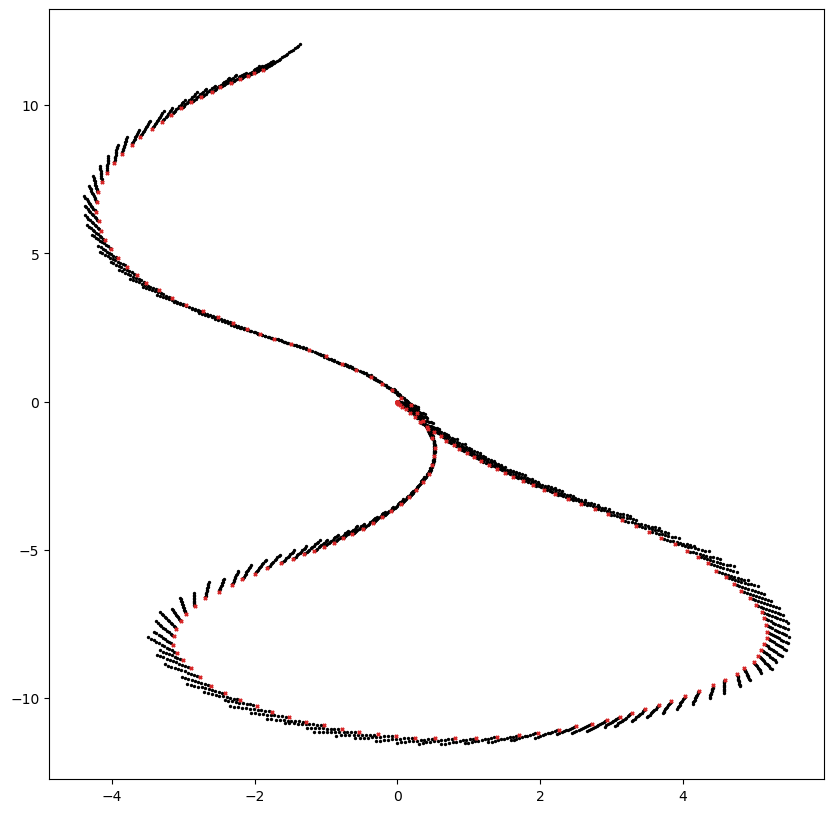

rmse: 0.19495849156681347
... logging to /home/tartila/.ros/log/632b1722-777e-11eb-ae06-74c63b0b1efd/roslaunch-tartila-G551VW-17045.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
It's recommended that you use the 'rosclean' command.
]2;/home/tartila/catkin_ws/src/golfi/launch/ukf_ule_ga.launch
started roslaunch server http://tartila-G551VW:39575/

SUMMARY

CLEAR PARAMETERS
 * /rosbag_play/
 * /rosbag_record/

PARAMETERS
 * /R_enc: 1e-06
 * /R_gnss: [0.09843, 0, 0, 0...
 * /R_imu: 1.894e-06
 * /R_tach: 5.538e-06
 * /initial_estimate_covariance_P: [16.2717976347517...
 * /process_noise_covariance_Q: [1.17431776295970...
 * /rosdistro: melodic
 * /rosversion: 1.14.10

NODES
  /
    rosbag_play (rosbag/play)
    rosbag_record (rosbag/record)
    ukf_localization_2d_ori (golfi/ukf_localization_2d_ori)
    utm (gps_common/utm_odometry_node)

ROS_MASTER_URI=http://localhost:11311
]2;/home/tartila/catkin_ws/src/golfi/launch/ukf_ule_ga.launch http

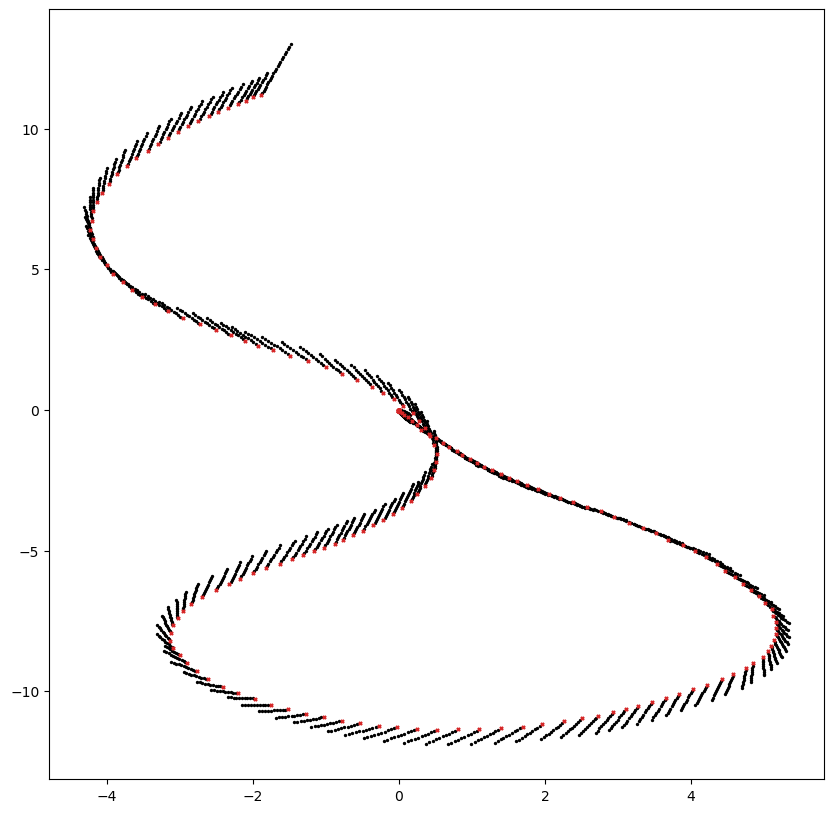

rmse: 0.32337803554811884
... logging to /home/tartila/.ros/log/632b1722-777e-11eb-ae06-74c63b0b1efd/roslaunch-tartila-G551VW-17118.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
It's recommended that you use the 'rosclean' command.
]2;/home/tartila/catkin_ws/src/golfi/launch/ukf_ule_ga.launch
started roslaunch server http://tartila-G551VW:40639/

SUMMARY

CLEAR PARAMETERS
 * /rosbag_play/
 * /rosbag_record/

PARAMETERS
 * /R_enc: 1e-06
 * /R_gnss: [0.09843, 0, 0, 0...
 * /R_imu: 1.894e-06
 * /R_tach: 5.538e-06
 * /initial_estimate_covariance_P: [17.9070356626707...
 * /process_noise_covariance_Q: [12.7324434580516...
 * /rosdistro: melodic
 * /rosversion: 1.14.10

NODES
  /
    rosbag_play (rosbag/play)
    rosbag_record (rosbag/record)
    ukf_localization_2d_ori (golfi/ukf_localization_2d_ori)
    utm (gps_common/utm_odometry_node)

ROS_MASTER_URI=http://localhost:11311
]2;/home/tartila/catkin_ws/src/golfi/launch/ukf_ule_ga.launch http

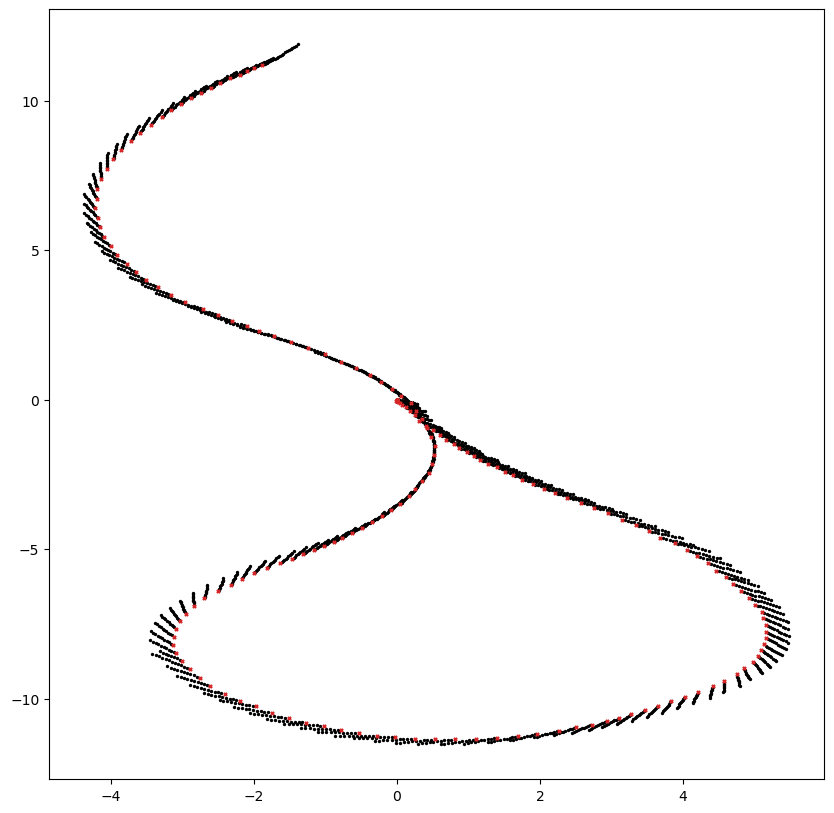

rmse: 0.1810142967125241
... logging to /home/tartila/.ros/log/632b1722-777e-11eb-ae06-74c63b0b1efd/roslaunch-tartila-G551VW-17185.log
Checking log directory for disk usage. This may take a while.
Press Ctrl-C to interrupt
It's recommended that you use the 'rosclean' command.
]2;/home/tartila/catkin_ws/src/golfi/launch/ukf_ule_ga.launch
started roslaunch server http://tartila-G551VW:39641/

SUMMARY

CLEAR PARAMETERS
 * /rosbag_play/
 * /rosbag_record/

PARAMETERS
 * /R_enc: 1e-06
 * /R_gnss: [0.09843, 0, 0, 0...
 * /R_imu: 1.894e-06
 * /R_tach: 5.538e-06
 * /initial_estimate_covariance_P: [10.5643976528288...
 * /process_noise_covariance_Q: [23.6995232525766...
 * /rosdistro: melodic
 * /rosversion: 1.14.10

NODES
  /
    rosbag_play (rosbag/play)
    rosbag_record (rosbag/record)
    ukf_localization_2d_ori (golfi/ukf_localization_2d_ori)
    utm (gps_common/utm_odometry_node)

ROS_MASTER_URI=http://localhost:11311
]2;/home/tartila/catkin_ws/src/golfi/launch/ukf_ule_ga.launch http:

In [ ]:
%%time
# Call an instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=swarm_size,
                                    dimensions=dim,
                                    options=options,
                                   bounds=constraints)

# Perform optimization

cost, covariance = optimizer.optimize(opt_func, iters=20)

In [ ]:
errorr = np.array(errorr)

In [ ]:
x = np.linspace(1,400,400)

In [ ]:

errorr3 = errorr

In [ ]:
for index, values in len(errorr3):
    print(index, values)

In [ ]:
arr =np.random.rand(96) * range_size + min_val

In [ ]:
with open('RMSEPSO.txt', 'w') as f:
    for item in errorr:
        f.write("%s\n" % item)


In [ ]:
    from numpy import genfromtxt

    my_data = genfromtxt('RMSEPSO.csv', delimiter=',')



In [ ]:
data[114] = 0.0606

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(x, errorr, label="RMSE")


plt.legend()

In [ ]:
best_cost = []

In [ ]:
best_cost = [0.0645,0.0638,0.0638,0.0638,0.0621,0.0621,0.0621,0.0606,0.0606,0.0606,0.0606,0.0606,0.0606,0.0606,0.0604,0.0604,0.0604,0.0604,0.0603,0.0598]

In [ ]:
best_cost = np.array(best_cost)

In [ ]:
best_cost.shape

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(np.linspace(1,400,20), best_cost, label="RMSE per Iteration")
plt.ylabel('RMSE')
plt.xlabel('Iteration')

plt.legend()

In [ ]:
data = []

In [ ]:
dataloop = np.arange(0,400,20)

In [ ]:
dataloop

In [ ]:
for j in range(1,20):
    dataloop[j] = dataloop[j] + 3

In [ ]:
for i in range(0,20):
    for j in range(0,16):
        data.append(my_data[dataloop[i]+j])

In [ ]:
data = np.array(data)

In [ ]:
data[68] = 0.0621

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(np.linspace(1,400,20), best_cost,'bo-',label="Best Cost per Iteration")
plt.plot(np.linspace(1,400,400), my_data,'o-',alpha=0.3, label="RMSE per particle")

plt.ylabel('RMSE')
plt.xlabel('Epoch')
# 16 1 16 2 16 3 16 4 16 5 16 6 16 7 16 8 15 9 16 10 16 11 16 12 16 13 16 14 16 15 16 17 16 18 16 19 16 20

plt.legend()

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(np.linspace(16,320,20), best_cost,'bo-',label="Best Cost per Iteration")
plt.plot(np.linspace(1,320,320), data,'o-',alpha=0.3, label="RMSE per particle")

plt.ylabel('RMSE')
plt.xlabel('Epoch')

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


plt.legend()

In [ ]:
z = np.linspace(1,400,20)

In [ ]:
z.shape